In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import mdpsolver

In [3]:
from gridworld import GridWorld

In [60]:
class MDP():
    def __init__(self, TPM, R_S, gamma=0.9):
        
        assert isinstance(TPM, torch.Tensor), "TPM must be a torch.Tensor"
        assert TPM.ndim == 3, "TPM must be a 3D tensor"
        assert TPM.shape[0] == TPM.shape[2], "TPM must be square"
        assert isinstance(R_S, torch.Tensor), "R_S must be a torch.Tensor"
        assert R_S.ndim == 1, "R_S must be a 1D tensor"
        assert R_S.shape[0] == TPM.shape[0], "Number of states in R_S must match number of states in TPM"
        assert isinstance(gamma, float), "gamma must be a float"

        self.TPM = TPM
        self.n_states = TPM.shape[0]
        self.n_actions = TPM.shape[1]
        self.R_S = R_S
        self.gamma = gamma

        self.value = None
        self.policy_list = None
        self.policy_matrix = None

        self.T = None # marginalised transition matrix
        self.M = None # successor representation

    def get_rewards_stateaction(self) -> list:
        """
        Get a list of of rewards for each action in each state, in preparation for 'MDPSolver'
        as we do not distinguish between actions in the reward function, we give the same reward for each action in each state
        """
        rewards = []
        for i in range(self.n_states):
            state_reward = []
            for j in range(self.n_actions):
                state_reward.append(self.R_S[i].item())
            rewards.append(state_reward)

        return rewards
    
    def get_TPM_sparse(self) -> torch.Tensor:
        """
        Get a sparse TPM in the format of "MDPSolver" 
        """
        tpm = self.TPM
        sparse = []
        for i in range(self.n_states):
            for j in range(4):
                for k in range(self.n_states):
                    if tpm[i, j, k] > 0:
                        sparse.append((i, j, k, float(tpm[i, j, k].item())))

        return sparse 

    def get_matrix_from_mdpsolver_policy(self, policy_list) -> torch.Tensor:
        """
        Convert the policy from mdpsolver (which is a 1D array of the best action for each state)
        to a 2D matrix representation of size [n_states, n_actions]
        """
        policy = np.array(policy_list)
        policy_matrix = torch.zeros(policy.shape[0], 4)
        for i in range(policy.shape[0]):
            policy_matrix[i, int(policy[i])] = 1.0

        return policy_matrix

    def solve(self):
        """
        Solve the MDP using the mdpsolver library
        """
        # Create a new MDP model instance
        mdl = mdpsolver.model()
        mdl.mdp(
            discount            = self.gamma,
            rewards             = self.get_rewards_stateaction(),
            tranMatElementwise  = self.get_TPM_sparse(),
        )
        # Solve the MDP
        mdl.solve(parallel=True)

        self.policy_list = mdl.getPolicy()
        self.policy_matrix = self.get_matrix_from_mdpsolver_policy(self.policy_list)
        self.value = mdl.getValueVector()

    def get_marginal_T(self):
        """
        Calculate the marginalised transition matrix T(s'|s) given the 
        optimal policy and the environmental transition probability matrix.
        """
        if self.policy_matrix is None:
            self.solve()
        
        T = torch.zeros((self.n_states, self.n_states), dtype=torch.float32)
        # M_{s,s'} = \sum_{a} \pi(a|s) T(s'|s,a)
        for s in range(self.n_states):
            for s_ in range(self.n_states):
                T[s, s_] = torch.sum(self.policy_matrix[s] * self.TPM[s, :, s_])

        self.T = T
    
    def get_SR_M(self):
        """
        Calculate the successor representation M(s,s') under the optimal policy
        """
        if self.T is None:
            self.get_marginal_T()
        
        # M(s,s') = (I - \gamma T)^{-1}
        M = torch.linalg.inv(torch.eye(self.n_states) - self.gamma * self.T)

        self.M = M

    
    

### Set up Gridworld with walls, wind, and friction

In [119]:
GAMMA = 0.9

gridworld = GridWorld(
    7, 7, 
    #wall_horiz=[[0, 1],[1, 2], [2, 3]], 
    #wall_vert=[[1, 1], [2, 2], [3, 3]],
    wall_vert= [[2, 1]],
    controllability=[0.6, 0.6], 
    wind=[-0.5, 0.0])

print("GridWorld:")
print(gridworld.grid)

GridWorld:
x―x―x―x―x―x―x―x
|             |
x x x x x x x x
|             |
x x x x x x x x
|             |
x x x x x x x x
|             |
x x x x x x x x
|             |
x x x x x x x x
|   |         |
x x x x x x x x
|             |
x―x―x―x―x―x―x―x



Controllability matrix C(s,s'):


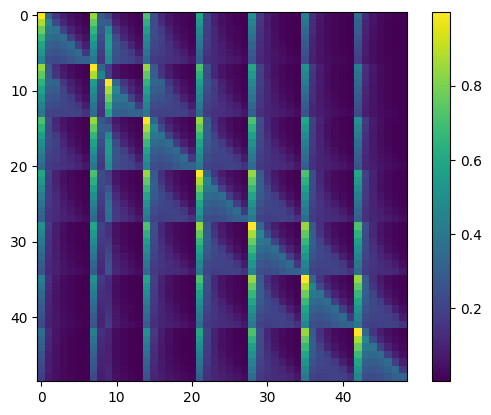

Affordance rate of states:


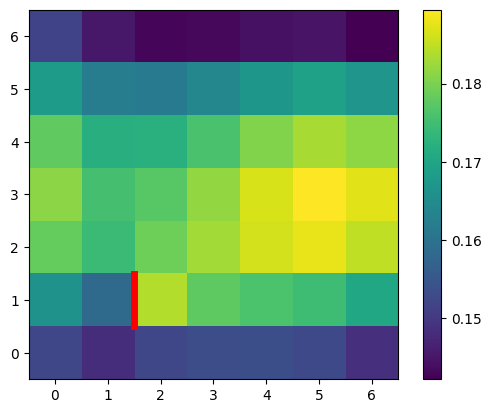

Affordance rate of overall system:
tensor(0.1681)


In [120]:
TPM = gridworld.get_TPM()
C = torch.zeros((gridworld.n_states, gridworld.n_states), dtype=torch.float32)

# Calculate the controllability matrix C(s,s') for each state
for i in range(gridworld.n_states):
    rewards = torch.zeros(gridworld.n_states)
    rewards[i] = 1.0
    mdp = MDP(TPM, rewards, gamma=GAMMA)
    mdp.get_SR_M()
    M = mdp.M
    M *= (1 - GAMMA) # normalise the successor representation
    # print(f"Successor representation M(s,s') for reward in state {i}:")
    # print(np.round(M.numpy(), 2))
    C[:, i] = M[:, i]

# Plot results
print("Controllability matrix C(s,s'):")
plt.imshow(C.numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

print("Affordance rate of states:")
c_bar = torch.mean(C, dim=1)
# wrap onto grid to show controllability of states
c_bar_grid = c_bar.reshape(gridworld.height, gridworld.width)

plt.imshow(c_bar_grid.numpy(), cmap='viridis', interpolation='nearest')
plt.gca().invert_yaxis()
plt.colorbar()

# draw walls from the gridworld
if gridworld.wall_horiz is not None:
    for wall in gridworld.wall_horiz:
        plt.plot([wall[0]-0.5, wall[1]-0.5], [wall[0]+0.5, wall[0]+0.5], color='red', linewidth=5)
if gridworld.wall_vert is not None:
    for wall in gridworld.wall_vert:
        plt.plot([wall[0]-0.5, wall[0]-0.5], [wall[1]-0.5, wall[1]+0.5], color='red', linewidth=5)

plt.show()

print("Affordance rate of overall system:")
c_bar_bar = torch.mean(C)
print(c_bar_bar)